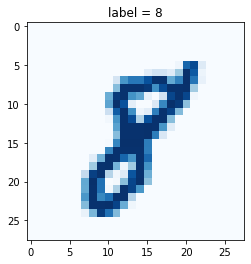

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

record = 17
mnist_dataset = MnistDataset('MNIST/mnist_train.csv')
mnist_dataset.plot_image(record)

In [2]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)


class Classifier(nn.Module):    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
        
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            View(250),
            nn.Linear(250, 10),
            nn.Sigmoid()
        )
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters())
        self.counter = 0
        self.progress = []
        pass
       
    def forward(self, inputs):
        return self.model(inputs)
        
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    pass

In [3]:
%%time 

C = Classifier()

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: total: 33min 9s
Wall time: 4min 8s


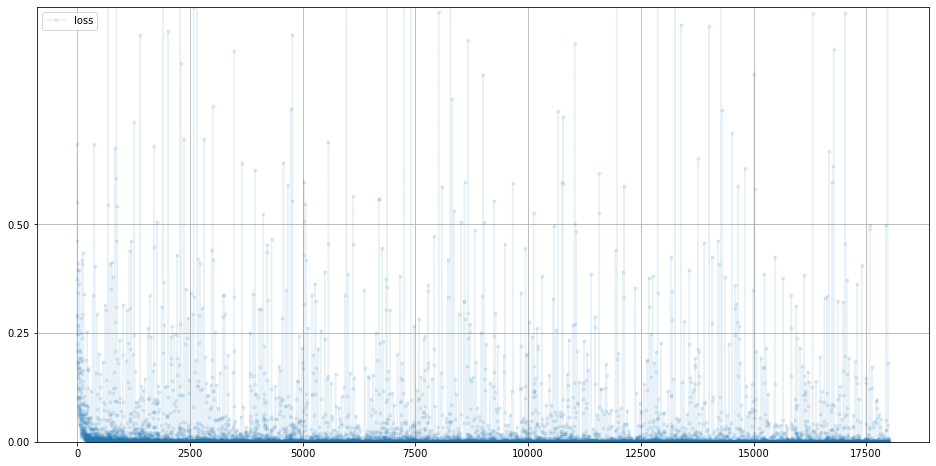

In [4]:
C.plot_progress()

<AxesSubplot:>

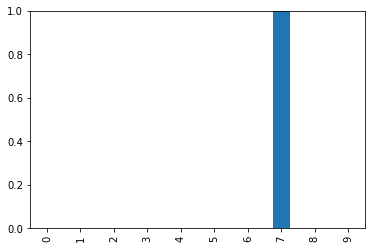

In [5]:
mnist_test_dataset = MnistDataset('MNIST/mnist_test.csv')

image_data = mnist_test_dataset[record][1]
output = C.forward(image_data.view(1,1,28,28))
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

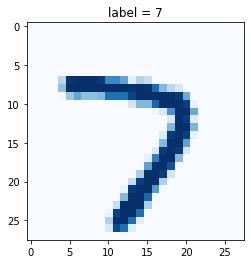

In [6]:
mnist_test_dataset.plot_image(record)

In [7]:
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor.view(1,1,28,28)).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    pass

print(score, items, score/items)

9796 10000 0.9796
